In [36]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow import keras
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import pandas as pd
import numpy as np

In [38]:
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# The Huber Loss unction

In [39]:
def create_huber(threshold=1.0):
    
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = error < threshold
        squared_loss = tf.squared(error) / 2
        linear_loss = threshold * tf.abs(error) - threshold**2 /2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

for sake of saving arguments such as 'threshold' when saving the model, creating subclass of keras.losses.Loss will solve the problem.

In [60]:
class HuberLoss(keras.losses.Loss):
    
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs)
        self.threshold = threshold
    
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss = self.threshold * tf.abs(error) - self.threshold**2 /2
        return tf.where(is_small_error, squared_loss, linear_loss)
    
    def get_config(self):
        base_cofig = super().get_config()
        return {**base_cofig, 'threshold': self.threshold}

In [61]:
model = Sequential()

model.add(Dense(20, activation='relu', input_shape=[8,]))

model.add(Dense(1))

#ex when compiling the model. 
model.compile(loss=HuberLoss(2.0), optimizer='nadam')

In [64]:
model.fit(X_train_scaled.astype(np.float32), y_train, epochs=4,
          validation_data=(X_valid_scaled.astype(np.float32), y_valid))

Epoch 1/4
363/363 [==============================] - 1s 2ms/step - loss: 0.1877 - val_loss: 0.2049
Epoch 2/4
363/363 [==============================] - 1s 1ms/step - loss: 0.1864 - val_loss: 0.1706
Epoch 3/4
363/363 [==============================] - 1s 2ms/step - loss: 0.1837 - val_loss: 0.1708
Epoch 4/4
363/363 [==============================] - 1s 2ms/step - loss: 0.1818 - val_loss: 0.1773


In [43]:
model.save('shimi_model_custom_loss_func.h5')

In [44]:
#ex when loading the model. It's not requred to specify the threshold value
model = keras.models.load_model('shimi_model_custom_loss_func.h5',
                               custom_objects={'HuberLoss': HuberLoss})

# Custom Huber Metric

In [45]:
class HuberMetric(keras.metrics.Metric):
    
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight('total', initializer='zeros')
        self.count = self.add_weight('count', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    
    def result(self):
        return self.total / self.count
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'threshold': threshold}

In [58]:
model = Sequential()

model.add(Dense(20, activation='selu', kernel_initializer='lecun_normal' ,input_shape=[8,]))

model.add(Dense(1))

#ex when compiling the model. metric==HuberMetric
model.compile(loss=HuberLoss(2.0), optimizer='nadam', metrics=[HuberMetric(2.0)])

In [65]:
model.fit(X_train_scaled.astype(np.float32), y_train, epochs=4,
          validation_data=(X_valid_scaled.astype(np.float32), y_valid))

Epoch 1/4
363/363 [==============================] - 1s 2ms/step - loss: 0.1817 - val_loss: 0.1828
Epoch 2/4
363/363 [==============================] - 1s 2ms/step - loss: 0.1796 - val_loss: 0.1956
Epoch 3/4
363/363 [==============================] - 1s 2ms/step - loss: 0.1787 - val_loss: 0.1689
Epoch 4/4
363/363 [==============================] - 1s 2ms/step - loss: 0.1767 - val_loss: 0.2056


# CUSTOM LAYERS

Adding an exponential layer at the output of a regression model can be useful if the values to predict are positive and with very different scales (e.g., 0.001, 10., 10000):

In [66]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))

In [67]:
exponential_layer([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787945, 1.        , 2.7182817 ], dtype=float32)>

# Custom Dense Layer

In [69]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)
    
    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
                    name='kernel', shape=[batch_input_shape[-1], self.units],
                    initializer='glorot_normal')
        self.bias = self.add_weight(
                    name='bias', shape=[self.units], initializer='zeros')
        super().build(batch_input_shape)
        
    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)
        
    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'units': self.units, 
               'activation': keras.activations.serialize(self.activation)}

Default Dense layers model

In [71]:
model = Sequential()

model.add(Dense(30, activation='relu', input_shape=[8,]))

model.add(Dense(1))

model.compile(loss='mse', optimizer='nadam')
model.fit(X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid), verbose=0)
model.evaluate(X_test_scaled, y_test, verbose=0)

0.4082992672920227

my custom layers model

In [72]:
model = Sequential()

model.add(MyDense(30, activation='relu', input_shape=[8,]))

model.add(MyDense(1))

model.compile(loss='mse', optimizer='nadam')
model.fit(X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid), verbose=0)
model.evaluate(X_test_scaled, y_test, verbose=0)

0.4026104509830475

In [76]:
model.save("my_model_with_custom_layer.h5")

In [78]:
model = keras.models.load_model('my_model_with_custom_layer.h5',
                               custom_objects={'MyDense': MyDense})

# Gaussian Noise Layer :: Regularization

Gaussian noise layer. # adding gaussian noise when trainning, but deactivate when testing

In [79]:
class MyGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev
        
    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X
        
    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

without Gaussian noise layers

In [90]:
model = Sequential()

model.add(Dense(60, activation='relu', input_shape=[8,]))
model.add(Dense(30, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(15, activation='relu'))

model.add(Dense(1))

model.compile(loss='mse', optimizer='nadam')
history = model.fit(X_train_scaled, y_train, epochs=50, validation_data=(X_valid_scaled, y_valid), verbose=0)
model.evaluate(X_test_scaled, y_test, verbose=0)

0.28310853242874146

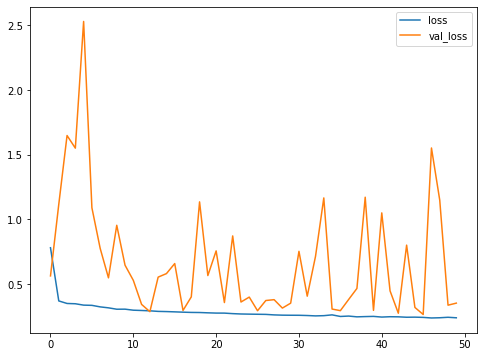

In [88]:
pd.DataFrame(history.history).plot(figsize=(8, 6));

val_loss is　

with Gaussian noise layers

In [82]:
model = Sequential()

model.add(MyDense(60, activation='relu', input_shape=[8,]))
model.add(MyGaussianNoise(1.))

model.add(MyDense(30, activation='relu'))

model.add(MyDense(20, activation='relu'))
model.add(MyGaussianNoise(1.))

model.add(MyDense(15, activation='relu'))

model.add(Dense(1))

model.compile(loss='mse', optimizer='nadam')
history = model.fit(X_train_scaled, y_train, epochs=50, validation_data=(X_valid_scaled, y_valid), verbose=0)
model.evaluate(X_test_scaled, y_test, verbose=0)

0.3378051519393921

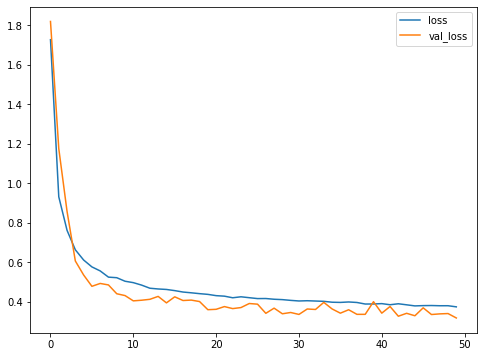

In [86]:
pd.DataFrame(history.history).plot(figsize=(8, 6));